In [3]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt

current_dir = os.getcwd().split('/')[-1]
if current_dir != 'pixelNMF':
    os.chdir('..')
    os.chdir('..')

from patchnmf.analyse.nmf import cv_nmf

from kneed import DataGenerator, KneeLocator

'''

Load preprocessed array and run batch cross validation for NMF

The output n_components is then saved into pixelnmf_params.xls (TO DO automate save)

'''

'\n\nLoad preprocessed array and run batch cross validation for NMF\n\nThe output n_components is then saved into pixelnmf_params.xls (TO DO automate save)\n\n'

In [4]:
os.getcwd()

'C:\\Users\\zaggila\\Documents\\deve_2p'

# data root for all preprocessed movies (for pattern analysis)

In [5]:
data_root_folder = r'C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels'

In [6]:
data_root = r'C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels'

In [7]:
def cv_nmf_run_AW(data_root, selected_datasets=None):
    import os
    import numpy as np

    cv_dict = {}

    for root_folder in os.listdir(data_root):
        root_path = os.path.join(data_root, root_folder)

        if not os.path.isdir(root_path):
            continue

        for subfolder in os.listdir(root_path):
            ds = os.path.join(root_folder, subfolder)  # e.g., 'sz119/2025_06_08_b'
            ds_path = os.path.join(data_root, ds)

            normalized_ds = ds.replace("\\", "/")  # unify path separators
            
            if selected_datasets is not None and normalized_ds not in selected_datasets:
                continue  # Skip if not in the selected list

            for subroot, dirs, files in os.walk(ds_path):
                preprocessed_npy_file = os.path.join(subroot, 'preprocessed_tiff.npy')

                if not os.path.exists(preprocessed_npy_file):
                    print(f'❌ Could not find {preprocessed_npy_file}')
                    continue

                try:
                    tiff_flat = np.load(preprocessed_npy_file)
                    print(f"✅ Loaded preprocessed npy for {ds}: {tiff_flat.shape}")
                except Exception as e:
                    print(f"⚠️ Error loading {preprocessed_npy_file}: {e}")
                    continue

                try:
                    train_err, test_err = cv_nmf(tiff_flat, r_max=30, step=2, replicates=1)
                    print(f'tr_err:{train_err}')
                    print(f'test_err:{test_err}')
                    save_path = os.path.join(ds_path, f'cv_{subfolder}.png')
                    n_nmf_min, n_nmf_elbow = plot_cv_opt(train_err, test_err, save_dir=save_path)

                    cv_dict[ds] = {
                        'train_err': train_err,
                        'test_err': test_err,
                        'n_nmf_min': n_nmf_min,
                        'n_nmf_elbow': n_nmf_elbow
                    }

                except Exception as e:
                    print(f"❌ Error during cv_nmf for {ds}: {e}")
                    continue
    
    return cv_dict

## cv_nmf_manual 

In [8]:
from sklearn.decomposition import NMF
import numpy as np
import itertools

def cv_nmf_sklearn(data, r_max, step, replicates, p_holdout=0.3, max_iter=10000, tol=1e-4):
    """
    Perform cross-validated NMF using scikit-learn's NMF implementation.
    
    Parameters:
    - data: Input dataset (2D array).
    - r_max: Maximum rank to test
    - step: Step size for ranks (e.g., test rank 10, 20, ..., r_max).
    - replicates: Number of replicates for each rank.
    - p_holdout: Proportion of data to hold out for testing (default 0.3).
    - max_iter: Maximum number of iterations for NMF (default 200).
    - tol: Tolerance for stopping criterion (default 1e-4).

    Returns:
    - train_err: List of training errors for each rank.
    - test_err: List of testing errors for each rank.
    """
    
    # Create ranks array
    ranks = np.arange(4, r_max+1, step)

    # Initialize error lists
    train_err = []
    test_err = []
    
    # Create a masking matrix for the missing data (1 = observed, 0 = held out) NOT 0
    M = np.random.rand(*data.shape) > p_holdout
    masked_data = np.where(M, data, np.median(data)) # any non zero (!) value why ? # https://github.com/kimjingu/nonnegfac-python black boxes become that number 
    
    # Loop through each rank and each replicate
    for rank, _ in itertools.product(ranks, range(replicates)):
        print(f"Fitting NMF with rank = {rank}")
        
        # Initialize and fit NMF model with scikit-learn
        model = NMF(n_components=rank, init='random', max_iter=max_iter, tol=tol, random_state=0)
        W = model.fit_transform(masked_data)
        H = model.components_
        
        # Reconstruct the data from the factorized matrices
        reconstructed_data = np.dot(W, H)
        
        # Calculate residual (difference between actual and reconstructed data)
        resid = reconstructed_data - data
        
        # Calculate training and testing errors
        train_err_r = np.mean(resid[M] ** 2)  # Only consider observed data in training
        test_err_r = np.mean(resid[~M] ** 2)  # Only consider held-out data in testing
        
        # Append the errors
        train_err.append((rank, train_err_r))
        test_err.append((rank, test_err_r))
        
        print(f"Finished running for rank: {rank} | Training error: {train_err_r:.4f}, Test error: {test_err_r:.4f}")

    return train_err, test_err

In [47]:
def plot_cv_opt(train_err, test_err, title, save_dir):
    train_err_np = np.array([te[1] for te in train_err])  # Extract train error values
    test_err_np = np.array([te[1] for te in test_err])    # Extract test error values
    ranks = np.array([te[0] for te in test_err])          # Extract rank values

    # Get the rank with the lowest test error
    idx_nmf_min = np.argmin(test_err_np) # idx of rank with min te
    n_nmf_min = ranks[idx_nmf_min] # actual x value (rank) with min te

    # Find the elbow point using kneelocator 
    knee_locator = KneeLocator(ranks, test_err_np, curve="convex", direction="decreasing")
    n_nmf_elbow = knee_locator.knee # x_value of the knee (rank)

    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=200)
    ax.set_title(title)
    ax.plot(ranks, train_err_np, 'o-', label='Train Data')
    ax.plot(ranks, test_err_np, 'o-', label='Test Data')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Rank')
    ax.axvline(n_nmf_min, color='grey', dashes=[1,1.5], label='min')

    if n_nmf_elbow is not None:
        ax.axvline(n_nmf_elbow, color='black', dashes=[1,1.5], label='elbow') # or ranks[n_nmf_elbow]

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', fontsize=10)
    fig.tight_layout()
    plt.savefig(save_dir + 'cv_nmf.png')
    plt.show()

    return n_nmf_min, n_nmf_elbow

## run all cv_nmf

In [48]:
# def cv_nmf_run_selected(data_root, selected_datasets=None):
#     import os
#     import numpy as np

#     cv_dict = {}

#     for root_folder in os.listdir(data_root):
#         root_path = os.path.join(data_root, root_folder)

#         if not os.path.isdir(root_path):
#             continue

#         for subfolder in os.listdir(root_path):
#             ds = os.path.join(root_folder, subfolder)  # e.g., 'sz119/2025_06_08_b'
#             ds_path = os.path.join(data_root, ds)

#             normalized_ds = ds.replace("\\", "/")  # unify path separators
            
#             if selected_datasets is not None and normalized_ds not in selected_datasets:
#                 continue  # Skip if not in the selected list

#             for subroot, dirs, files in os.walk(ds_path):
#                 preprocessed_npy_file = os.path.join(subroot, 'preprocessed_tiff.npy')

#                 if not os.path.exists(preprocessed_npy_file):
#                     print(f'❌ Could not find {preprocessed_npy_file}')
#                     continue

#                 try:
#                     tiff_flat = np.load(preprocessed_npy_file)
#                     print(f"✅ Loaded preprocessed npy for {ds}: {tiff_flat.shape}")
#                 except Exception as e:
#                     print(f"⚠️ Error loading {preprocessed_npy_file}: {e}")
#                     continue

#                 try:
#                     train_err, test_err = cv_nmf_sklearn(tiff_flat, r_max=50, step=2, replicates=1)
#                     save_path = os.path.join(ds_path, f'cv_{subfolder}.png')
#                     n_nmf_min, n_nmf_elbow = plot_cv_opt(train_err, test_err, save_dir=save_path)

#                     cv_dict[ds] = {
#                         'train_err': train_err,
#                         'test_err': test_err,
#                         'n_nmf_min': n_nmf_min,
#                         'n_nmf_elbow': n_nmf_elbow
#                     }

#                 except Exception as e:
#                     print(f"❌ Error during cv_nmf for {ds}: {e}")
#                     continue
    
#     return cv_dict

In [49]:
os.listdir(data_root)

['sz004',
 'sz014',
 'sz015',
 'sz016',
 'sz018',
 'sz019',
 'sz020',
 'sz025',
 'sz026',
 'sz027',
 'sz030',
 'sz031',
 'sz034',
 'sz037',
 'sz038',
 'sz040',
 'sz080',
 'sz088',
 'sz089',
 'sz090',
 'sz091',
 'sz092',
 'sz095',
 'sz101',
 'sz105',
 'sz116',
 'sz119']

# Compute all 

In [50]:
data_root

'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels'

In [51]:
results_json = os.path.join(data_root, "cv_results.json")
results_xlsx = os.path.join(data_root, "cv_results.xlsx")

In [52]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

def cv_nmf_run_all(data_root):
    """
    Run cv_nmf_sklearn on all datasets under data_root and save results iteratively:
    - Excel: cv_results.xlsx (updated after each dataset)
    - Numpy dict: cv_results.npy (updated after each dataset)
    CV plot images remain under each dataset folder.
    """
    
    # --- Central results folder ---
    results_folder = os.path.join(data_root, 'cv_nmf')
    os.makedirs(results_folder, exist_ok=True)
    
    results_xlsx = os.path.join(results_folder, 'cv_results.xlsx')
    results_npy  = os.path.join(results_folder, 'cv_results.npy')
    
    # --- Load existing NumPy dict if available ---
    if os.path.exists(results_npy):
        cv_dict = np.load(results_npy, allow_pickle=True).item()
        print(f"✅ Loaded existing results with {len(cv_dict)} entries.")
    else:
        cv_dict = {}

    # --- Loop through sz*/subfolders ---
    for root_folder in os.listdir(data_root):
        root_path = os.path.join(data_root, root_folder)
        if not os.path.isdir(root_path) or not root_folder.startswith("sz"):
            continue

        for subfolder in os.listdir(root_path):
            ds = os.path.join(root_folder, subfolder)
            ds_path = os.path.join(data_root, ds)
            normalized_ds = ds.replace("\\", "/")

            # # Skip if not in selected list
            # if selected_datasets is not None and normalized_ds not in selected_datasets:
            #     continue

            # Skip if already processed
            if normalized_ds in cv_dict:
                print(f"⏩ Skipping {normalized_ds} (already processed)")
                continue

            print(f"📂 Processing dataset: {normalized_ds}")

            # --- Find preprocessed_tiff.npy ---
            preprocessed_npy_file = None
            for subroot, dirs, files in os.walk(ds_path):
                candidate = os.path.join(subroot, 'preprocessed_tiff.npy')
                if os.path.exists(candidate):
                    preprocessed_npy_file = candidate
                    break

            if preprocessed_npy_file is None:
                print(f"❌ Could not find preprocessed_tiff.npy in {ds_path}")
                continue

            # --- Load data ---
            try:
                tiff_flat = np.load(preprocessed_npy_file)
                print(f"✅ Loaded preprocessed array: {tiff_flat.shape}")
            except Exception as e:
                print(f"⚠️ Error loading {preprocessed_npy_file}: {e}")
                continue

            try:
                # --- Run sklearn NMF ---
                train_err_sk, test_err_sk = cv_nmf_sklearn(tiff_flat, r_max=50, step=2, replicates=1)
                
                # --- CV plot saved in dataset folder ---
                save_path_sk = os.path.join(ds_path, f'cv_sk_{subfolder}.png')
                n_min_sk, n_elbow_sk = plot_cv_opt(train_err_sk, test_err_sk,
                                                   title=f'{normalized_ds} cv_nmf_SK',
                                                   save_dir=save_path_sk)

                # --- Update results dict ---
                cv_dict[normalized_ds] = {
                    'train_err_sk': train_err_sk,
                    'test_err_sk': test_err_sk,
                    'n_nmf_min_sk': n_min_sk,
                    'n_nmf_elbow_sk': n_elbow_sk,
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                }

                # --- Save NumPy dict iteratively ---
                np.save(results_npy, cv_dict)
                print(f"💾 Saved NumPy dict at {results_npy}")

                # --- Update Excel iteratively ---
                df_summary = pd.DataFrame([{
                    'dataset': normalized_ds,
                    'train_err_min_sk': min([x[1] for x in train_err_sk]),
                    'test_err_min_sk': min([x[1] for x in test_err_sk]),
                    'n_nmf_min_sk': n_min_sk,
                    'n_nmf_elbow_sk': n_elbow_sk,
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                }])

                if os.path.exists(results_xlsx):
                    existing_df = pd.read_excel(results_xlsx)
                    updated_df = pd.concat([existing_df, df_summary]).drop_duplicates(subset='dataset', keep='last')
                else:
                    updated_df = df_summary

                updated_df.to_excel(results_xlsx, index=False)
                print(f"📊 Updated Excel summary at {results_xlsx}")

            except Exception as e:
                print(f"❌ Error processing {normalized_ds}: {e}")
                continue

    print("✅ All datasets processed successfully.")
    return cv_dict


📂 Processing dataset: sz004/2021-11-30_c
✅ Loaded preprocessed array: (3600, 3025)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 18
Finished running for rank: 18 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 20
Finished running for rank: 20 | Training error: 0.0001, Test error: 0.0002
Fitti

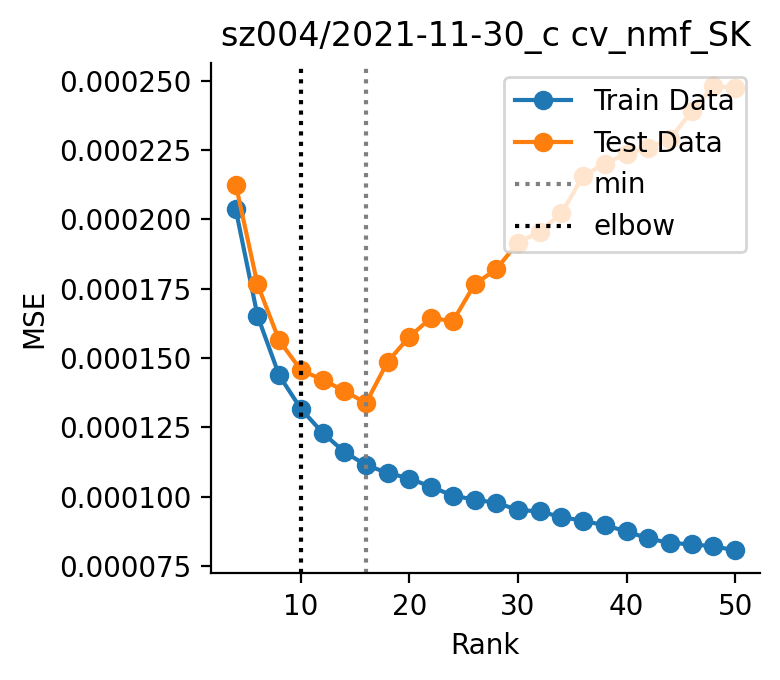

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz014/2022-01-07_c
✅ Loaded preprocessed array: (3600, 2970)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0001, Test error: 0.0001
Fitting N

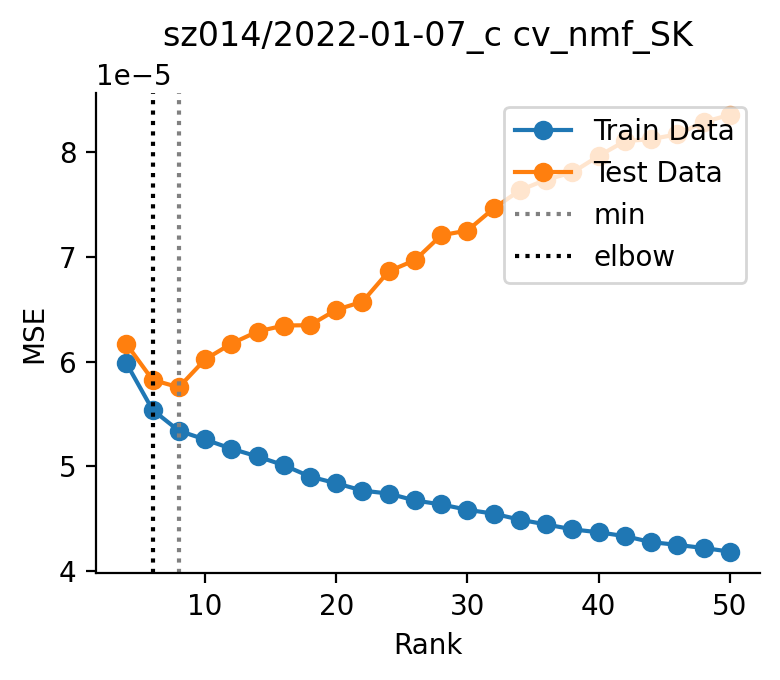

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz014/2022-01-07_c: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz015/2022-01-07_b
✅ Loaded preprocessed array: (3600, 3025)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | 

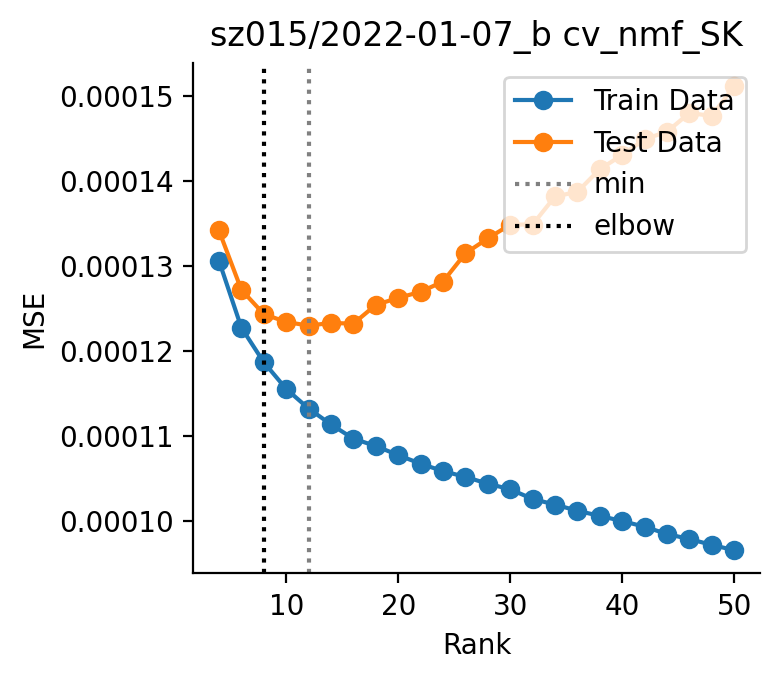

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz015/2022-01-07_b: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz016/2022-01-10_b
✅ Loaded preprocessed array: (6000, 3025)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | 

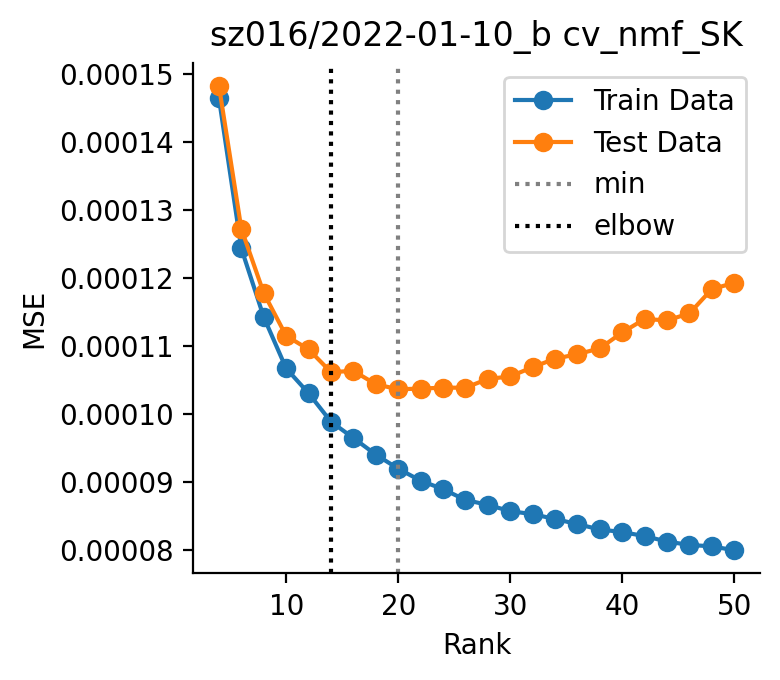

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz016/2022-01-10_b: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz018/2022-01-21_b
✅ Loaded preprocessed array: (6000, 3025)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 16
Finished running for rank: 16 | 

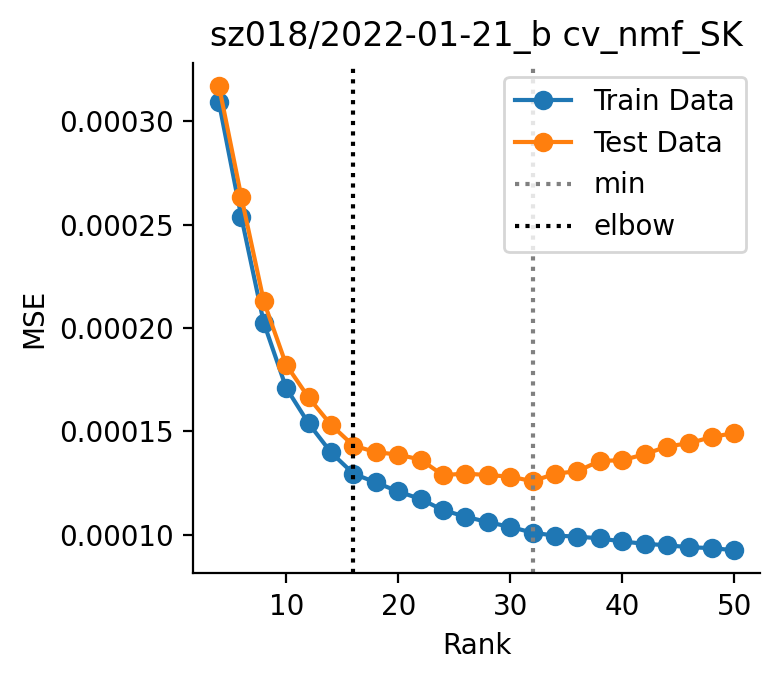

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz018/2022-01-21_b: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz019/2022-03-09_d
❌ Could not find preprocessed_tiff.npy in C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz019\2022-03-09_d
📂 Processing dataset: sz019/2022_01_21_d
✅ Loaded preprocessed array: (6000, 3025)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fittin

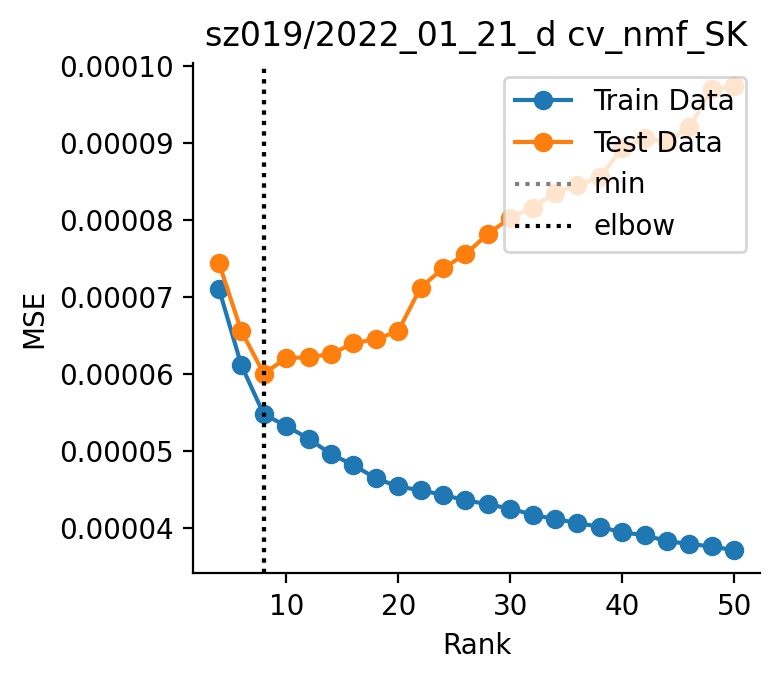

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz019/2022_01_21_d: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz020/2022-01-21_a
✅ Loaded preprocessed array: (5000, 3025)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 | 

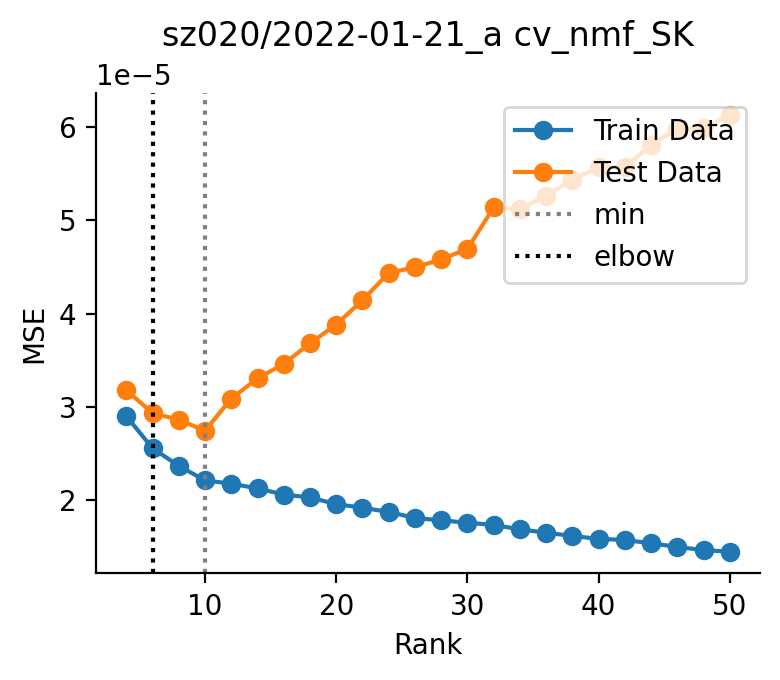

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz020/2022-01-21_a: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz020/2022-01-21_b
❌ Could not find preprocessed_tiff.npy in C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz020\2022-01-21_b
📂 Processing dataset: sz025/2022-03-09_e
✅ Loaded preprocessed array: (4000, 2401)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fittin

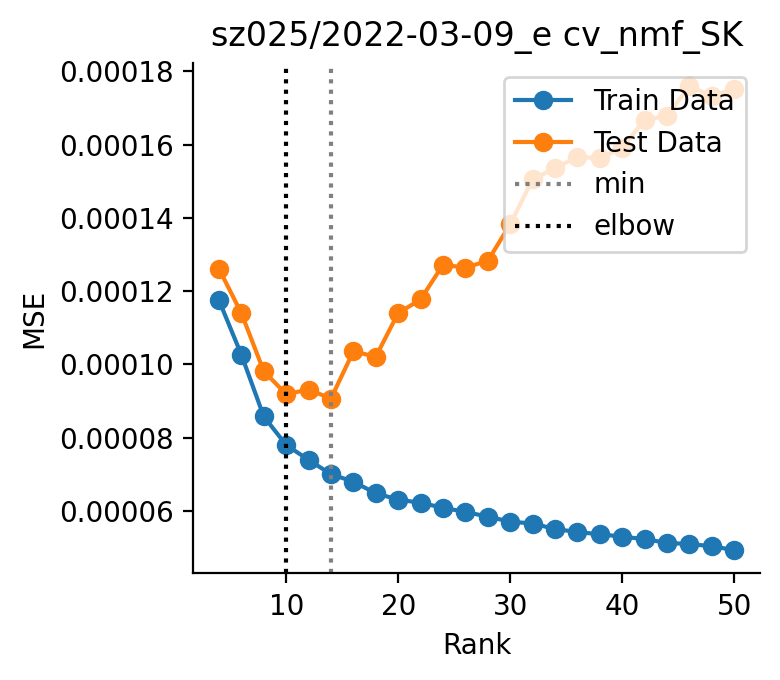

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz025/2022-03-09_e: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz026/2022-03-10_d
✅ Loaded preprocessed array: (6000, 3025)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 16
Finished running for rank: 16 | 

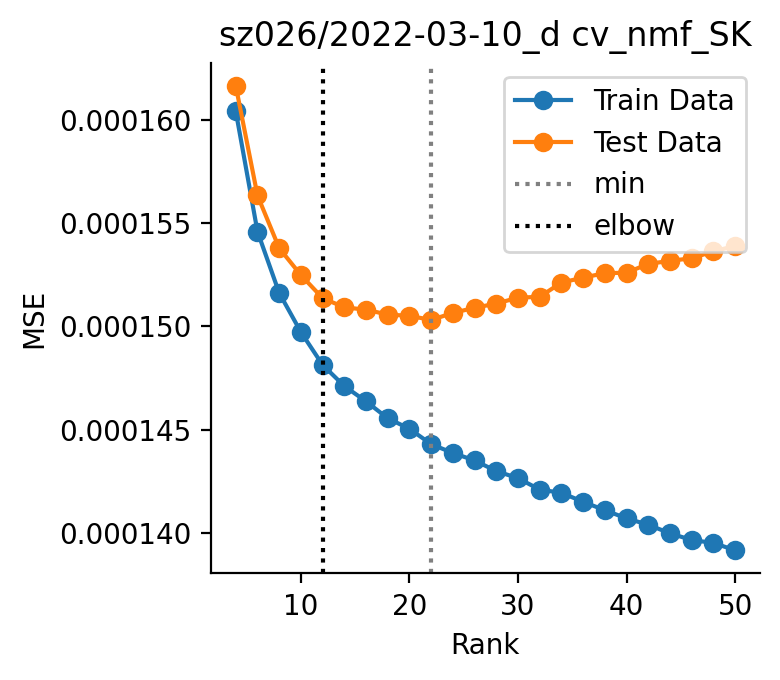

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz026/2022-03-10_d: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz027/2022-03-09_d
✅ Loaded preprocessed array: (6000, 3025)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | 

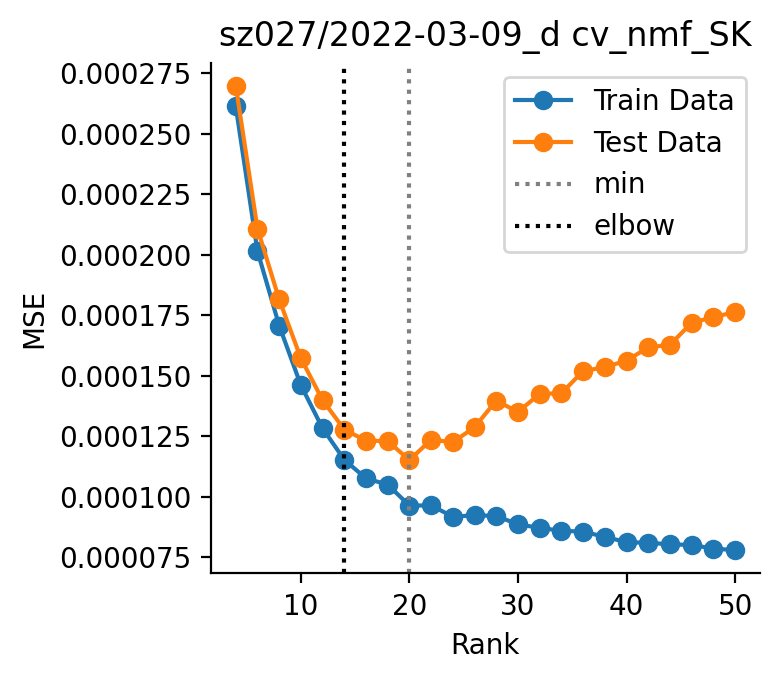

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz027/2022-03-09_d: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz030/2022-03-30_a
✅ Loaded preprocessed array: (3600, 5776)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | 

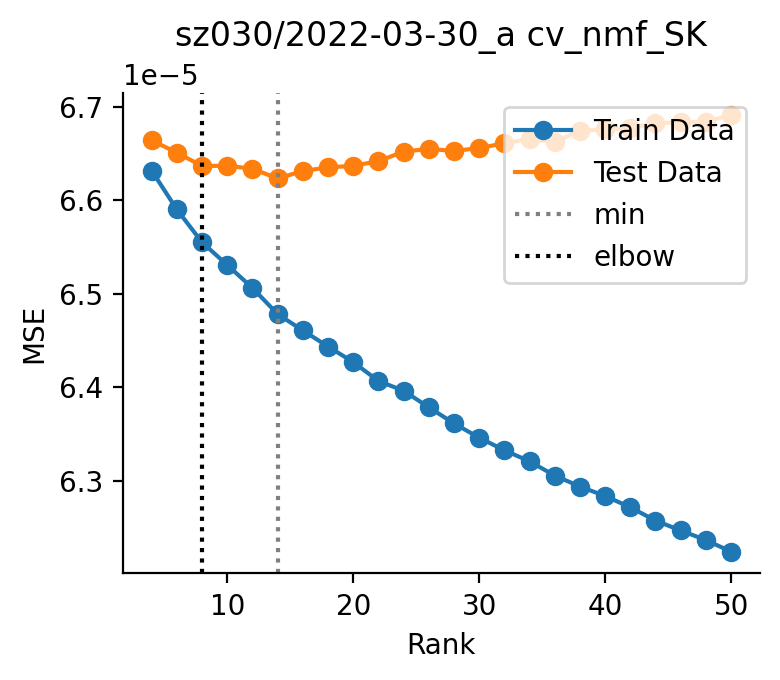

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz030/2022-03-30_a: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz030/2022-03-30_b
✅ Loaded preprocessed array: (3600, 1600)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | 

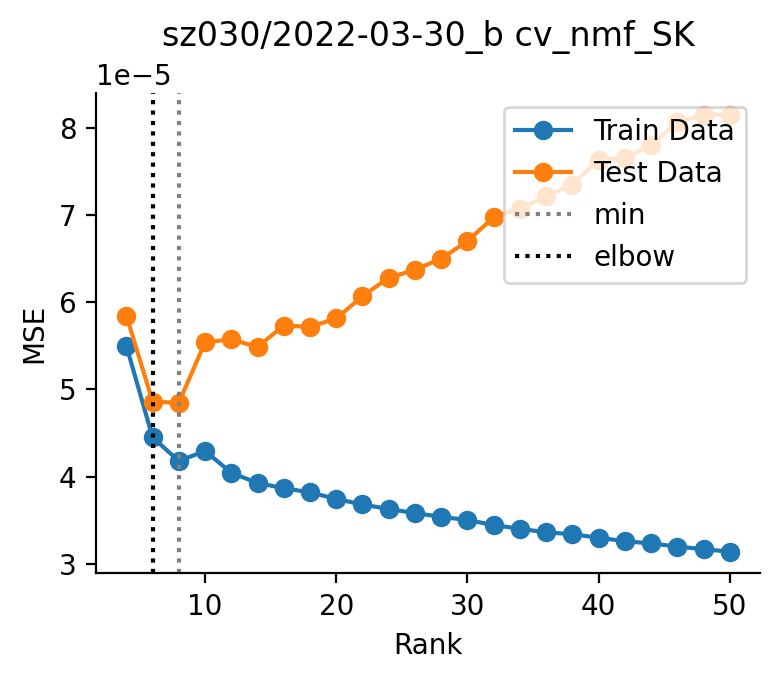

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz030/2022-03-30_b: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz031/2022-03-31_b
✅ Loaded preprocessed array: (3360, 1764)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | 

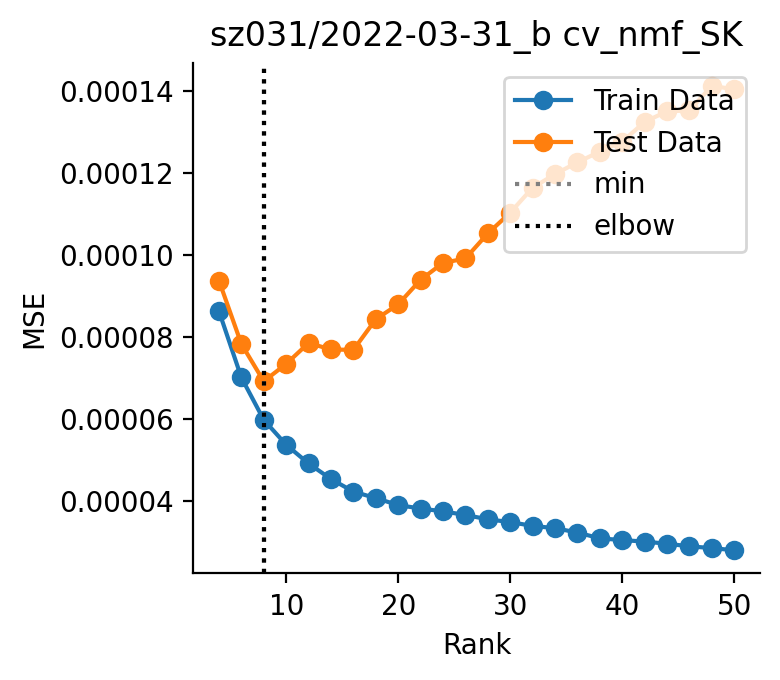

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz031/2022-03-31_b: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz034/2022-05-12_a
✅ Loaded preprocessed array: (1800, 14690)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 |

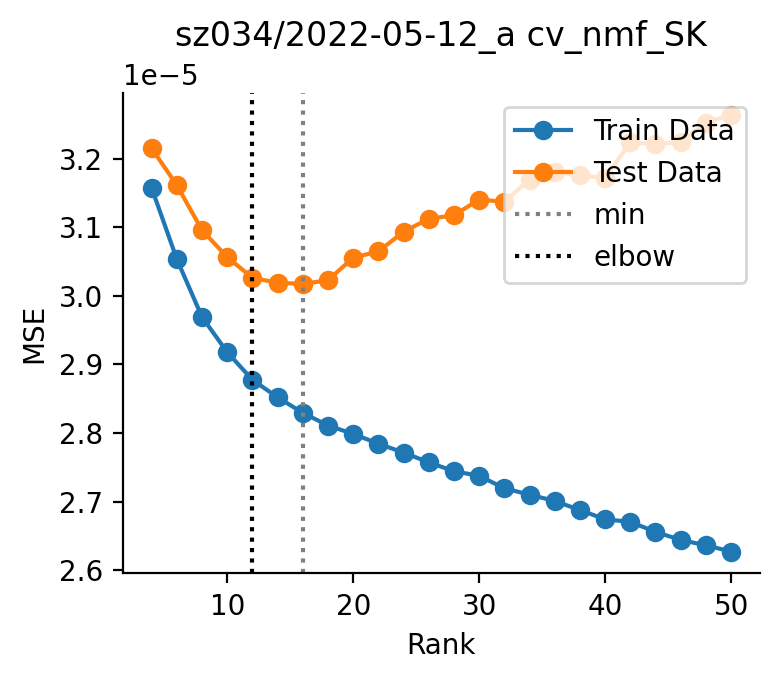

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz034/2022-05-12_a: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz034/2022-05-13_a
✅ Loaded preprocessed array: (1800, 12769)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 |

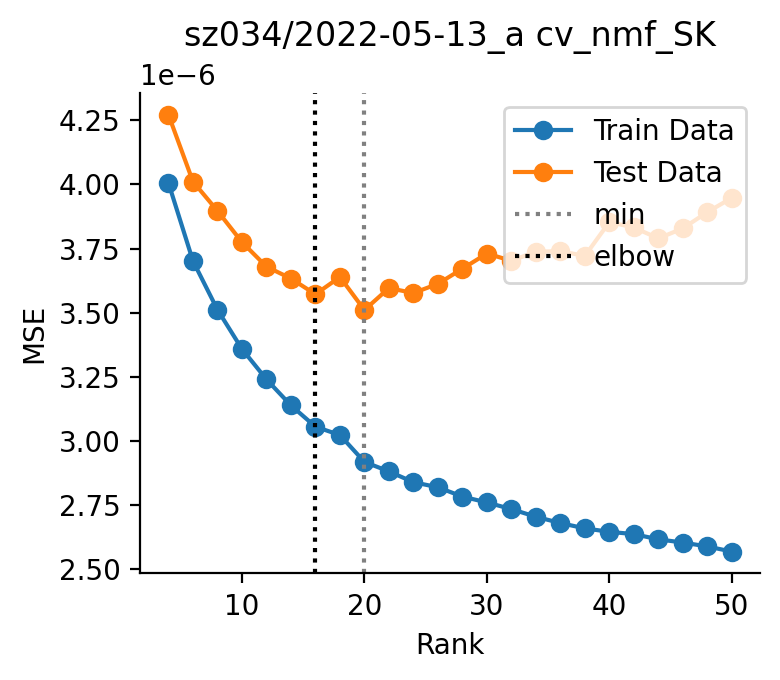

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz034/2022-05-13_a: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz037/2022-05-16_b
✅ Loaded preprocessed array: (1800, 17689)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 |

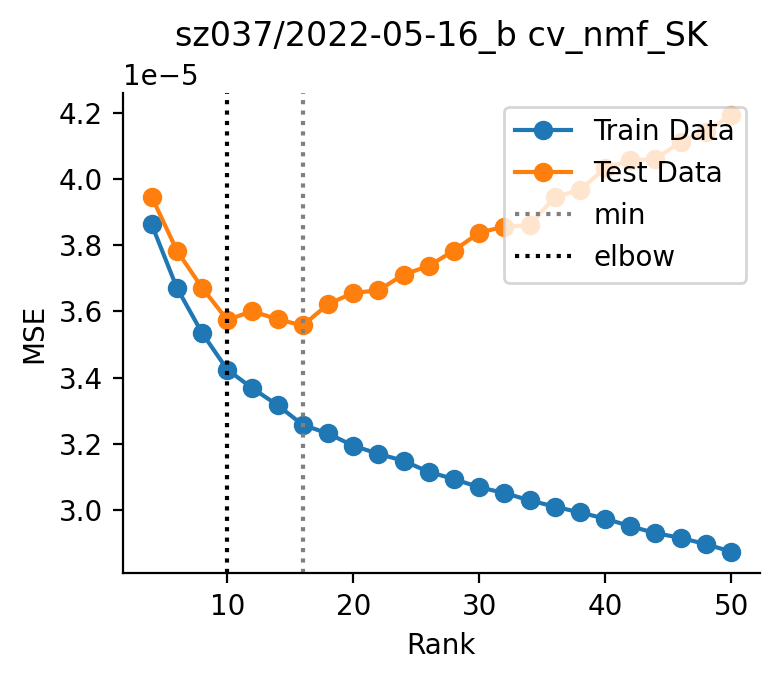

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz037/2022-05-16_b: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz038/2022-05-17_a
✅ Loaded preprocessed array: (1800, 17689)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 |

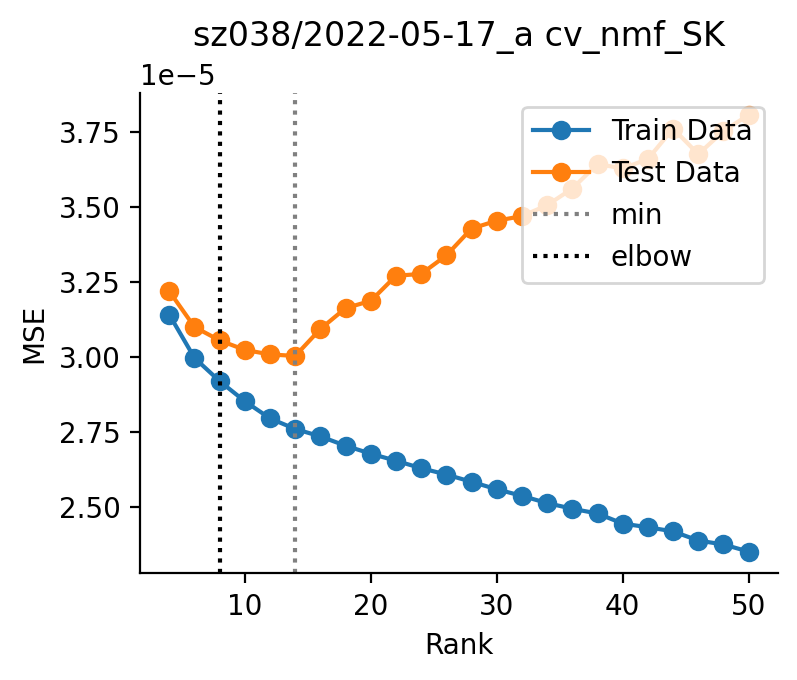

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz038/2022-05-17_a: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz038/2022-05-19_a
✅ Loaded preprocessed array: (1800, 17689)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 |

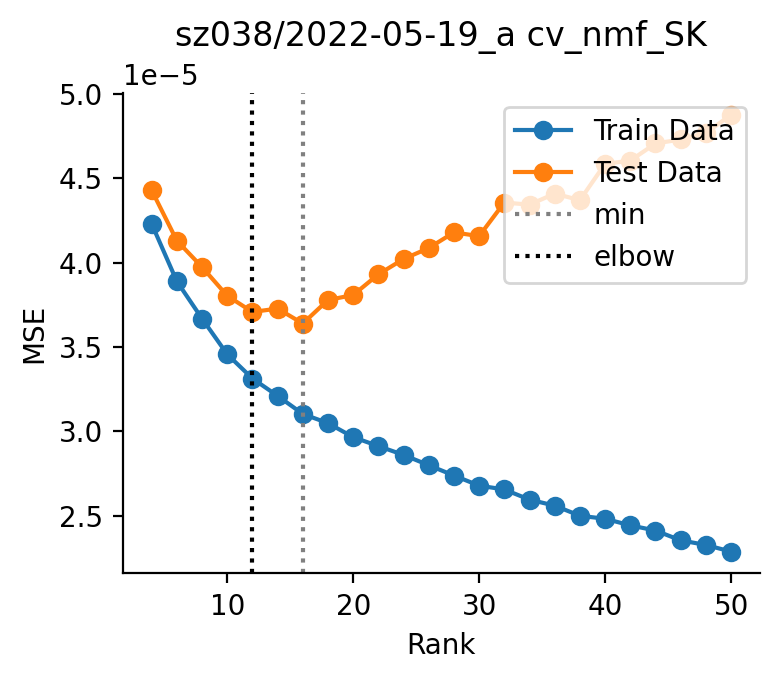

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz038/2022-05-19_a: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz040/2022-05-18_a
✅ Loaded preprocessed array: (3600, 17689)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 |

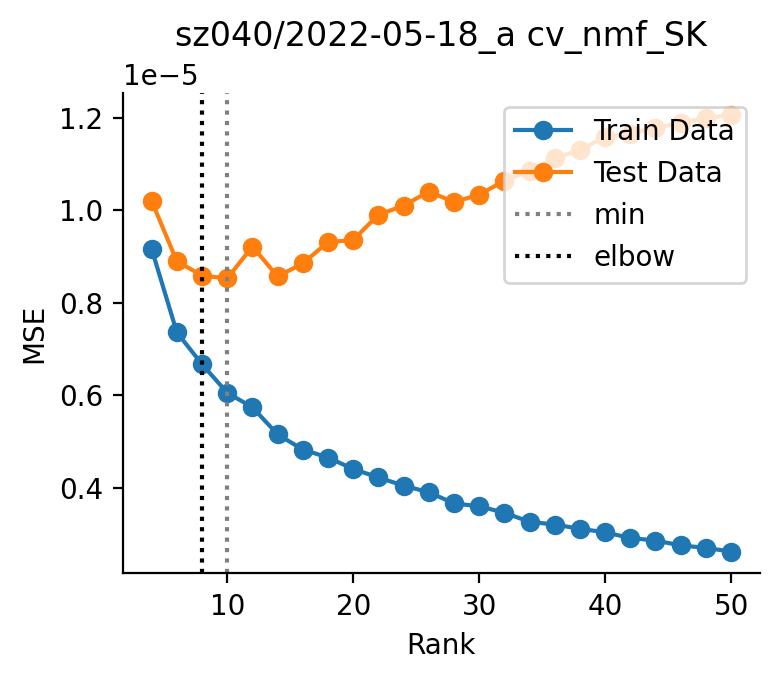

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz040/2022-05-18_a: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz080/2024_02_23_b
✅ Loaded preprocessed array: (3600, 12769)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 16
Finished running for rank: 16 |

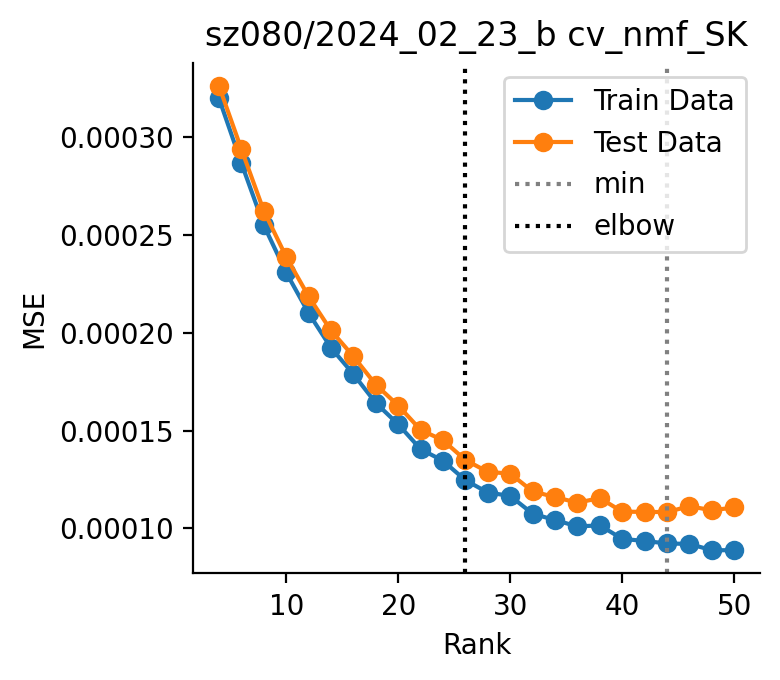

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz080/2024_02_23_b: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz088/2024-06-03_a
✅ Loaded preprocessed array: (3600, 12769)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0003, Test error: 0.0003
Fitting NMF with rank = 16
Finished running for rank: 16 |

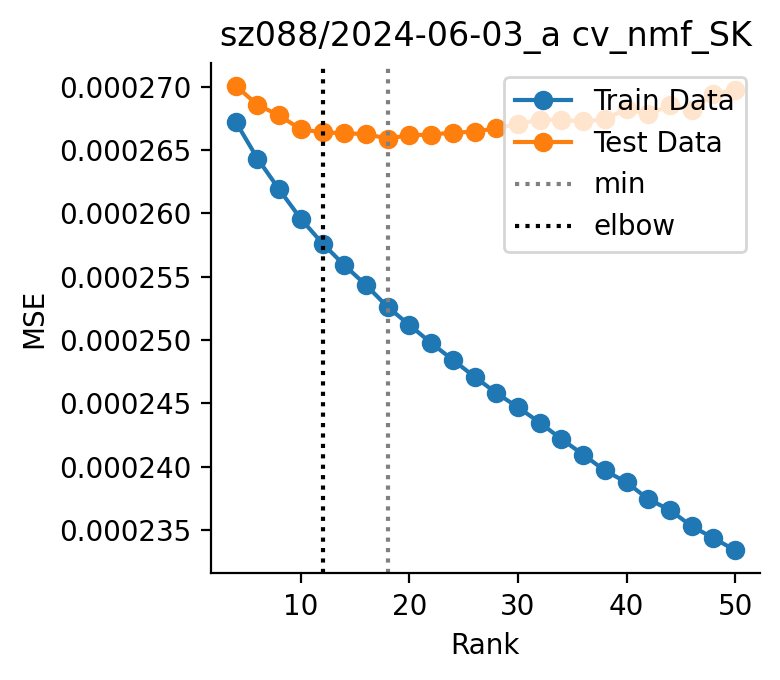

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
❌ Error processing sz088/2024-06-03_a: [Errno 13] Permission denied: 'C:\\Users\\zaggila\\Documents\\pixelNMF\\data_proc\\pixels\\cv_nmf\\cv_results.xlsx'
📂 Processing dataset: sz088/preprocessed_tiff
❌ Could not find preprocessed_tiff.npy in C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz088\preprocessed_tiff
📂 Processing dataset: sz089/2024_06_04_a
✅ Loaded preprocessed array: (3600, 11881)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.

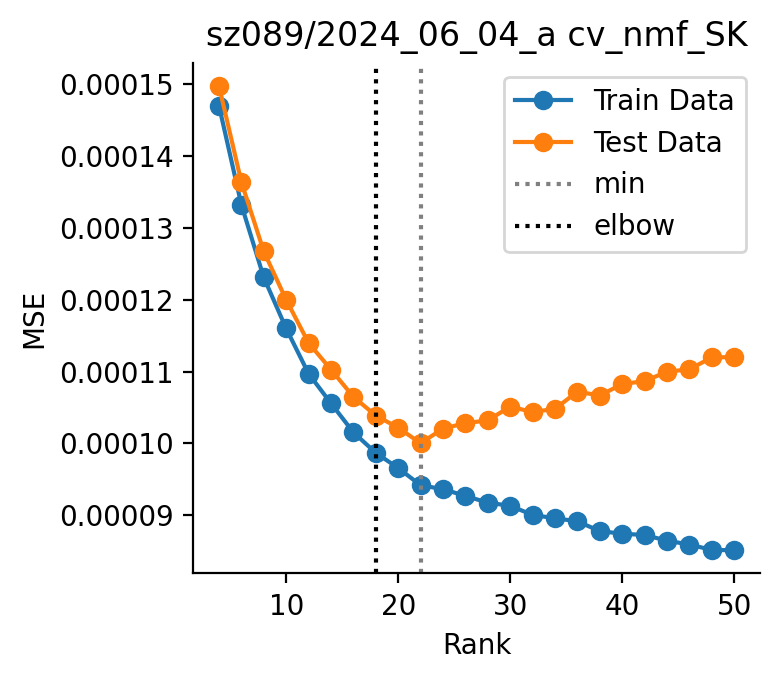

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz089/2024_06_06_a
✅ Loaded preprocessed array: (3600, 16641)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0002, Test error: 0.0002
Fitting 

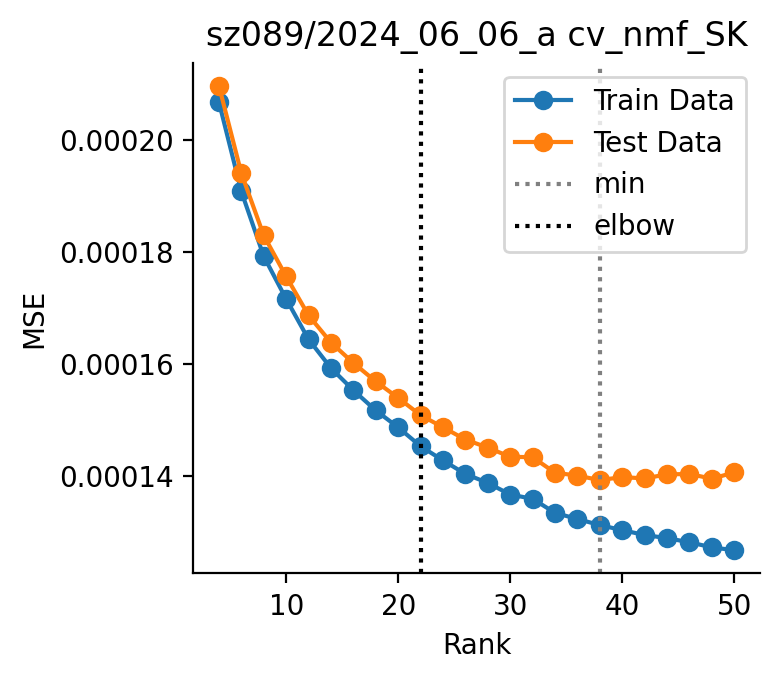

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz089/2024_06_07_a
✅ Loaded preprocessed array: (3600, 16641)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0000, Test error: 0.0001
Fitting 

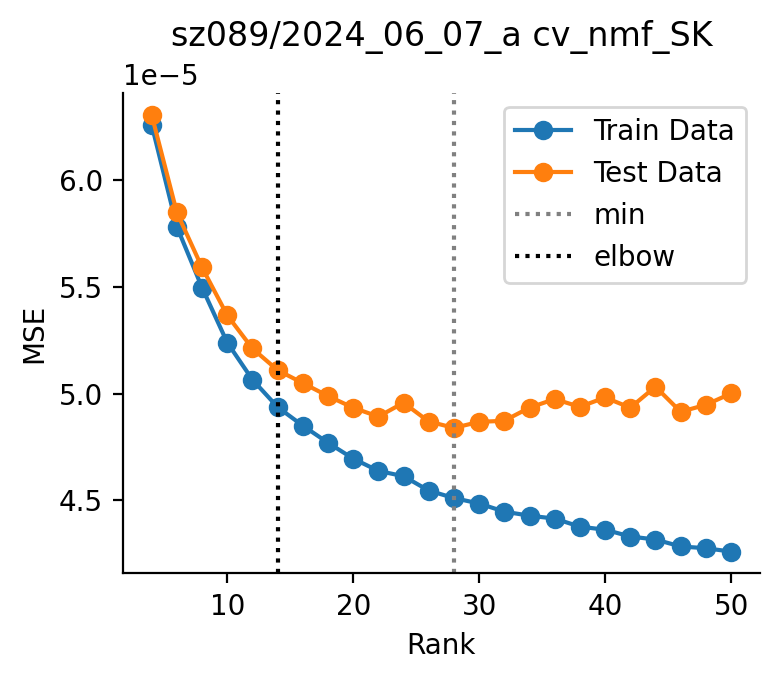

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz090/2024-06-05_a
✅ Loaded preprocessed array: (3600, 5329)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0000, Test error: 0.0000
Fitting N

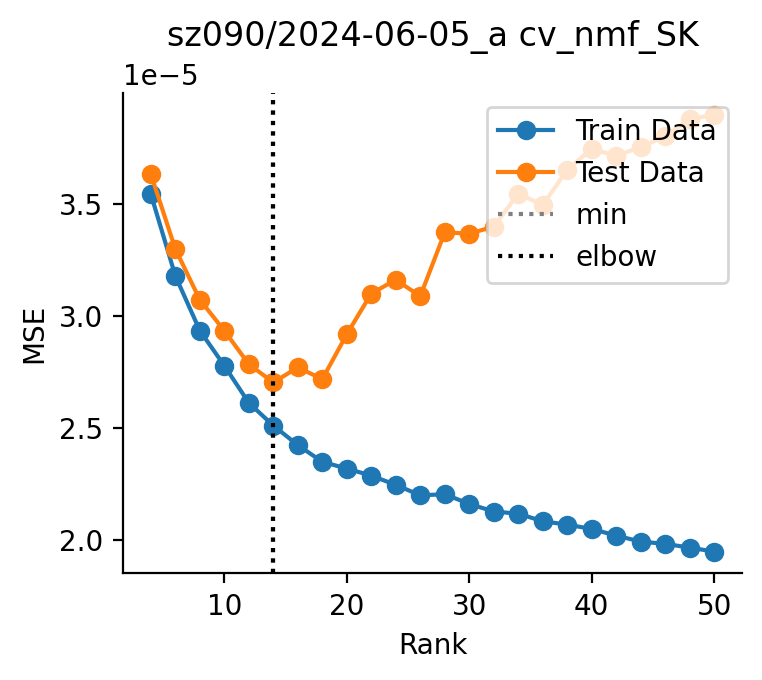

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz090/2024-06-06_a
✅ Loaded preprocessed array: (3600, 16641)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0001, Test error: 0.0001
Fitting 

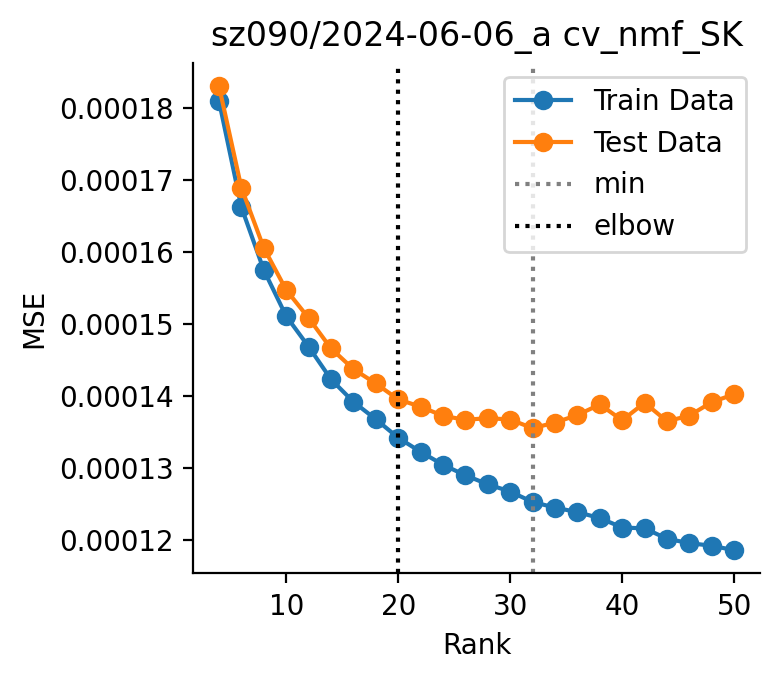

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz090/2024-06-07_a
✅ Loaded preprocessed array: (3600, 16641)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0001, Test error: 0.0001
Fitting 

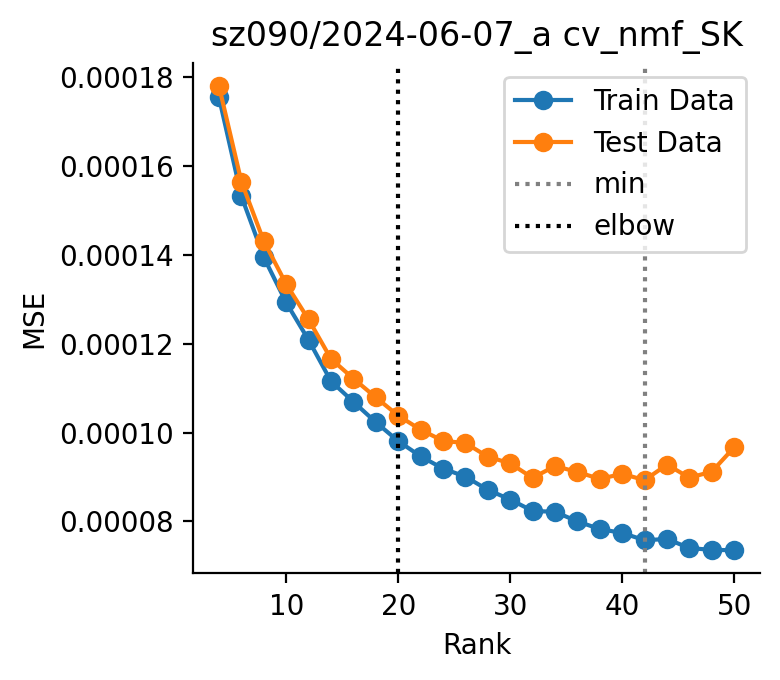

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz091/2024_06_05_b
✅ Loaded preprocessed array: (3600, 12769)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0001, Test error: 0.0001
Fitting 

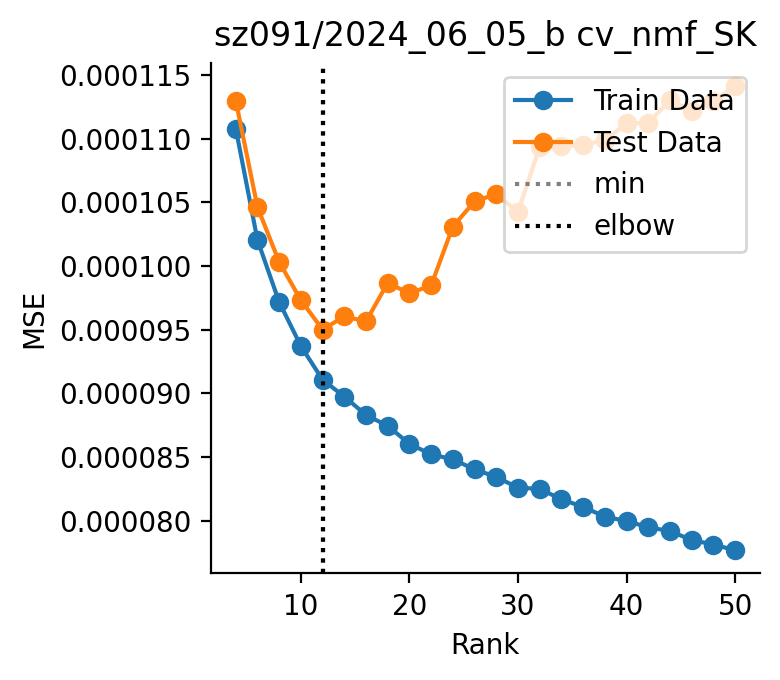

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz092/2024-06-06_a
✅ Loaded preprocessed array: (3600, 11881)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0001, Test error: 0.0001
Fitting 

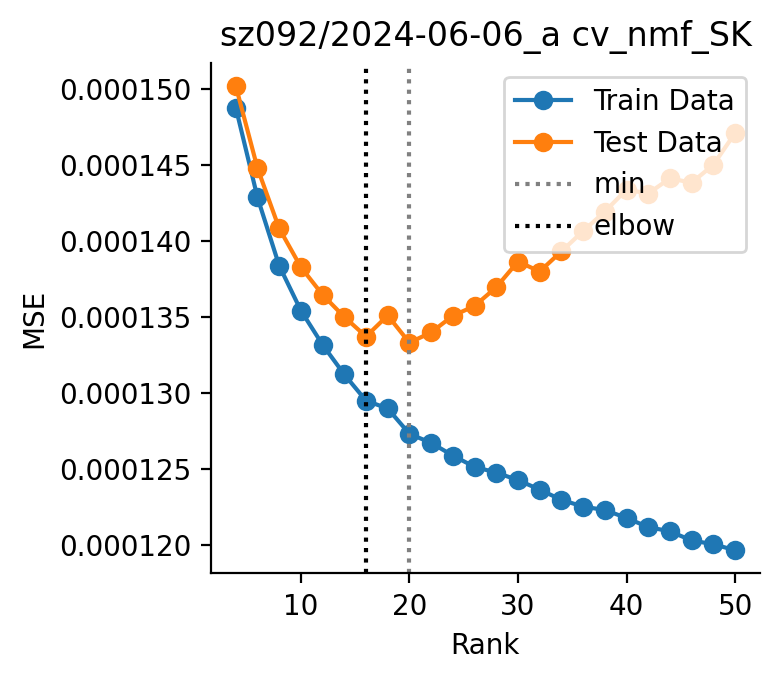

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz092/2024_06_07_a
✅ Loaded preprocessed array: (3600, 11881)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0002
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0001, Test error: 0.0001
Fitting 

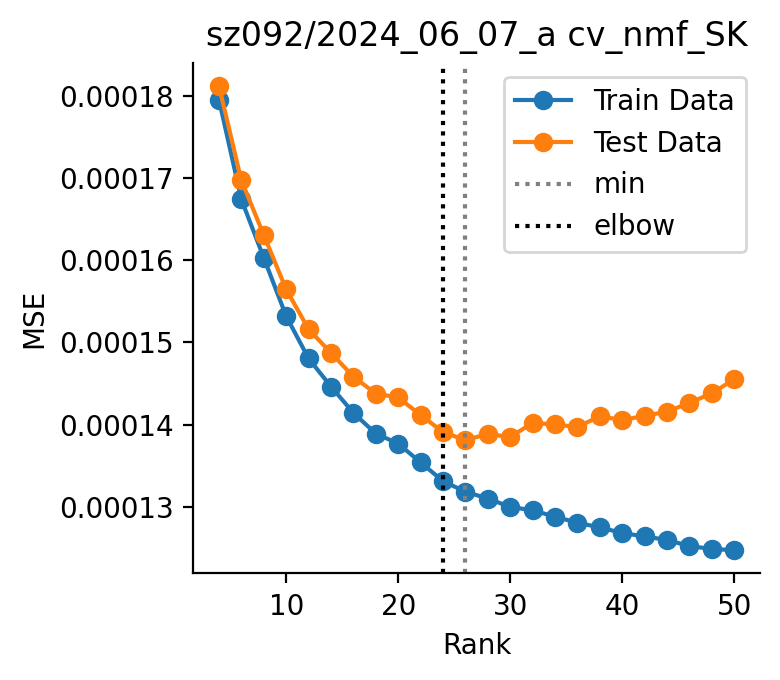

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz095/2025-01-09_a
✅ Loaded preprocessed array: (3600, 11881)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0000, Test error: 0.0000
Fitting 

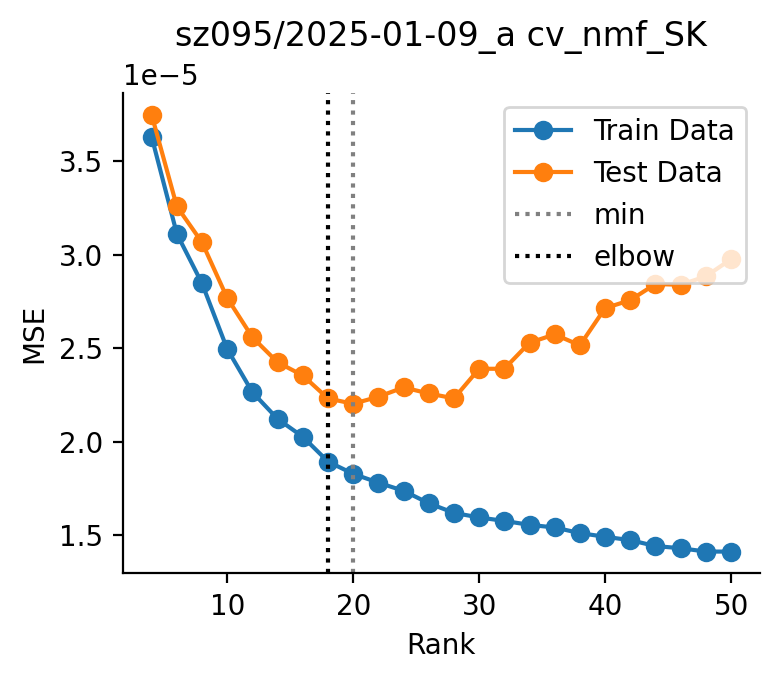

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz095/2025_01_09_b
✅ Loaded preprocessed array: (3600, 16641)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0000, Test error: 0.0000
Fitting 

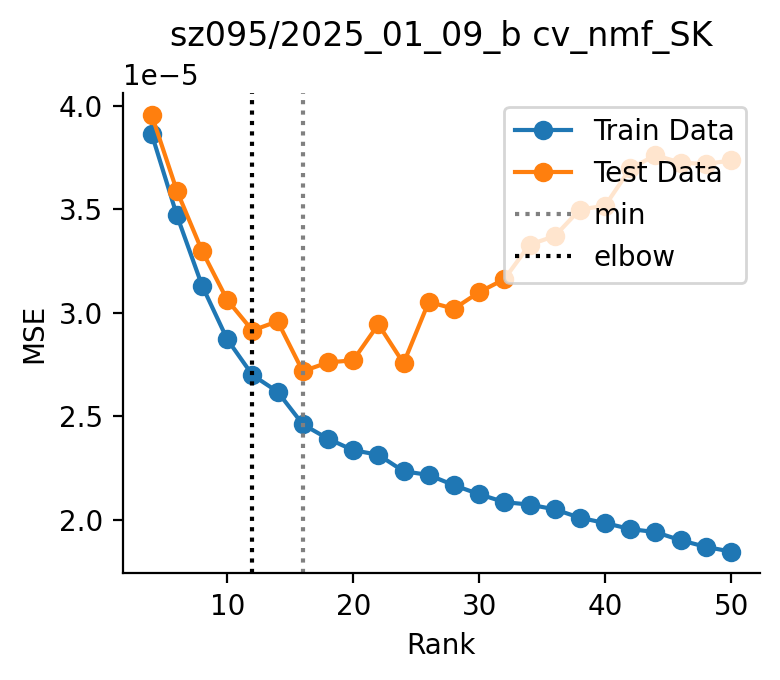

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz101/2025_04_12_a
✅ Loaded preprocessed array: (3600, 9216)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0000, Test error: 0.0000
Fitting N

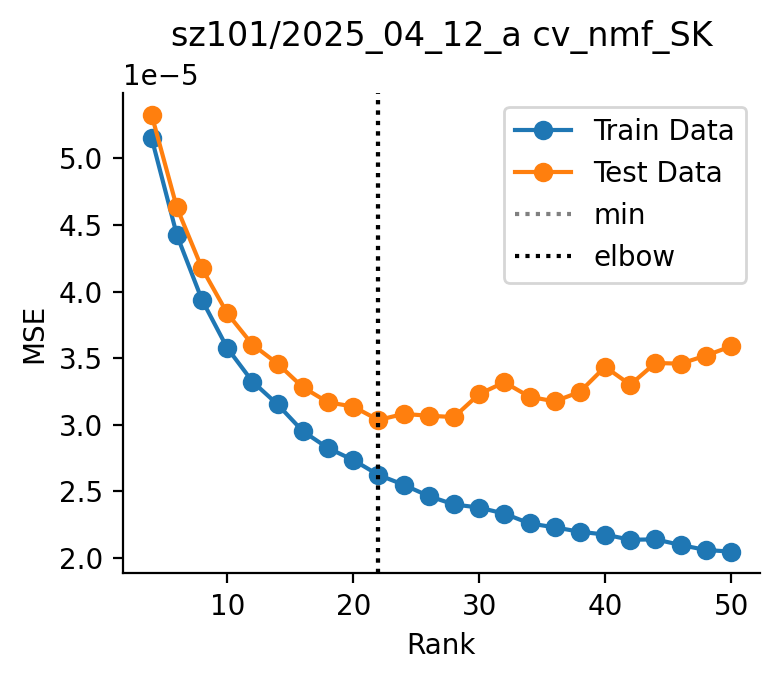

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz101/2025_04_13_a
❌ Could not find preprocessed_tiff.npy in C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz101\2025_04_13_a
📂 Processing dataset: sz101/2025_04_13_b
✅ Loaded preprocessed array: (3600, 12769)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 

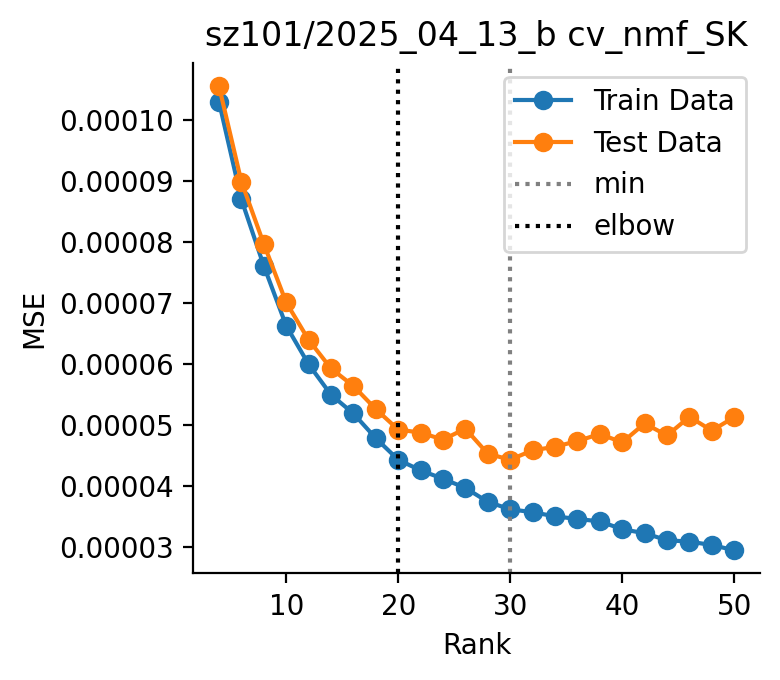

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz101/2025_04_14_a
❌ Could not find preprocessed_tiff.npy in C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz101\2025_04_14_a
📂 Processing dataset: sz101/2025_04_14_b
❌ Could not find preprocessed_tiff.npy in C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz101\2025_04_14_b
📂 Processing dataset: sz105/2025_05_29_a
❌ Could not find preprocessed_tiff.npy in C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz105\2025_05_29_a
📂 Processing dataset: sz105/2025_05_30_a
❌ Could not find preprocessed_tiff.npy in C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz105\2025_05_30_a
📂 Processing dataset: sz116/2025_06_07_a
✅ Loaded preprocessed array: (5400, 12321)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0

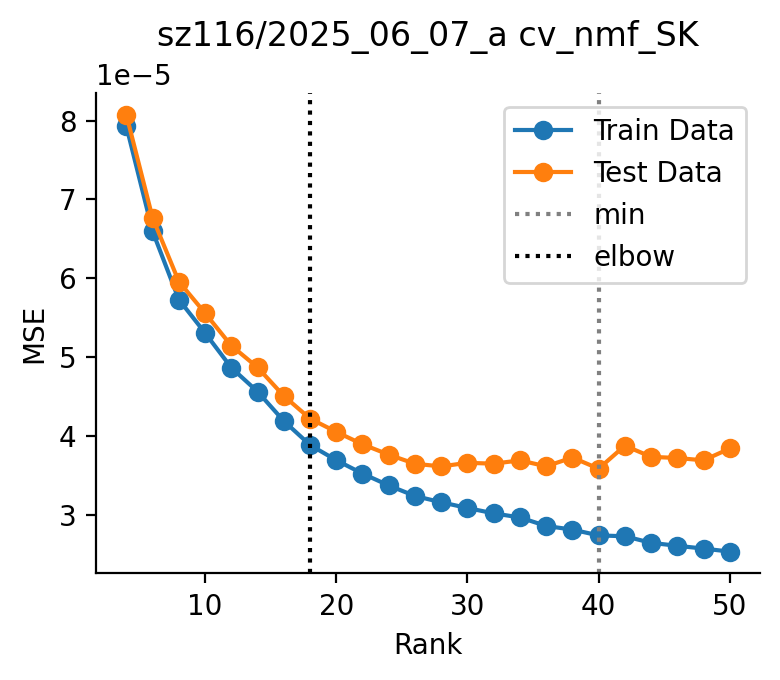

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz116/2025_06_07_b
✅ Loaded preprocessed array: (5400, 12321)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0000, Test error: 0.0000
Fitting 

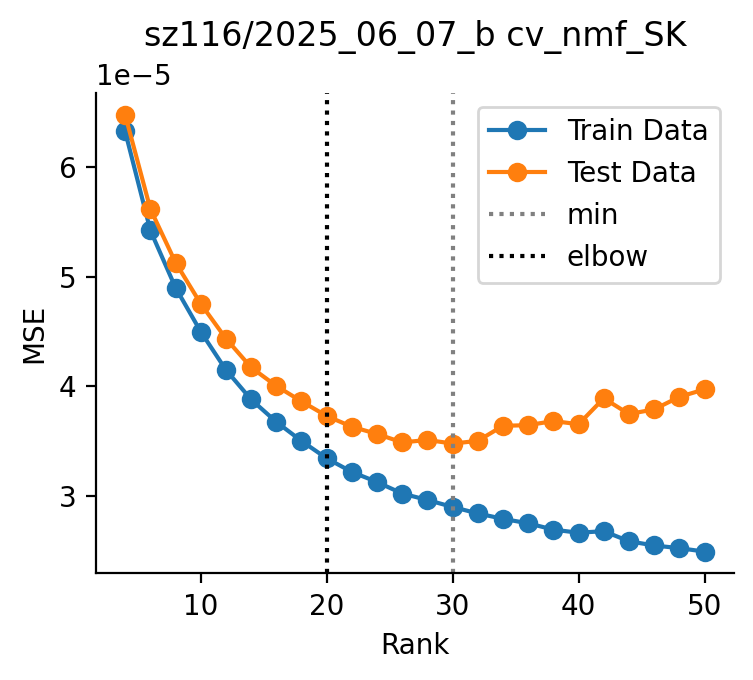

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz116/2025_06_07_d
✅ Loaded preprocessed array: (3600, 12321)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0000, Test error: 0.0000
Fitting 

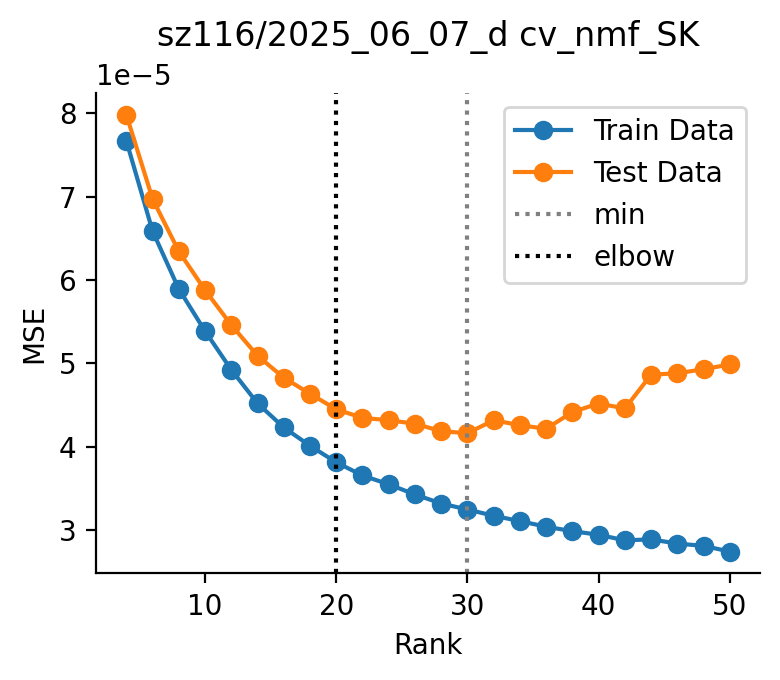

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz119/2025_06_08_a
✅ Loaded preprocessed array: (5400, 12769)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0001, Test error: 0.0001
Fitting 

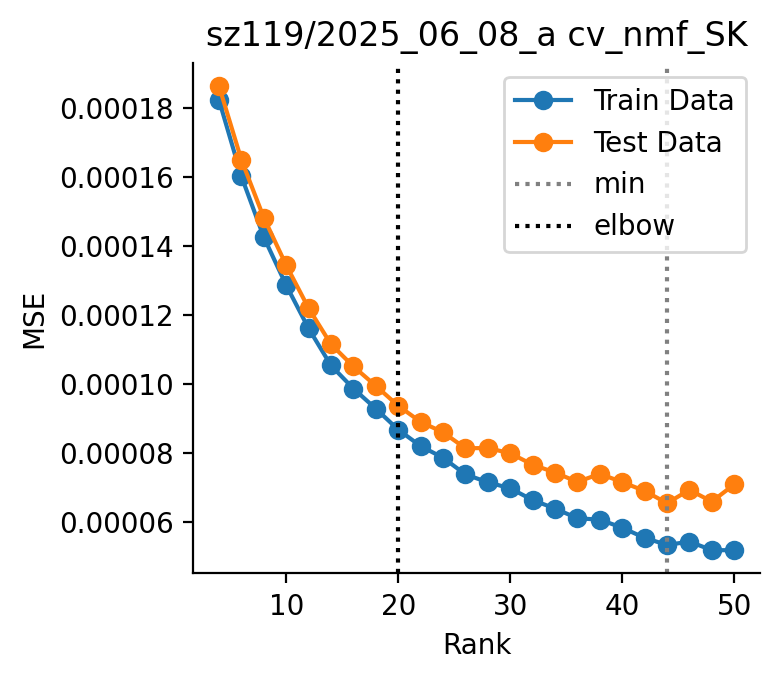

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
📂 Processing dataset: sz119/2025_06_08_b
✅ Loaded preprocessed array: (5400, 12769)
Fitting NMF with rank = 4
Finished running for rank: 4 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 6
Finished running for rank: 6 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 8
Finished running for rank: 8 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 10
Finished running for rank: 10 | Training error: 0.0000, Test error: 0.0001
Fitting NMF with rank = 12
Finished running for rank: 12 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 14
Finished running for rank: 14 | Training error: 0.0000, Test error: 0.0000
Fitting NMF with rank = 16
Finished running for rank: 16 | Training error: 0.0000, Test error: 0.0000
Fitting 

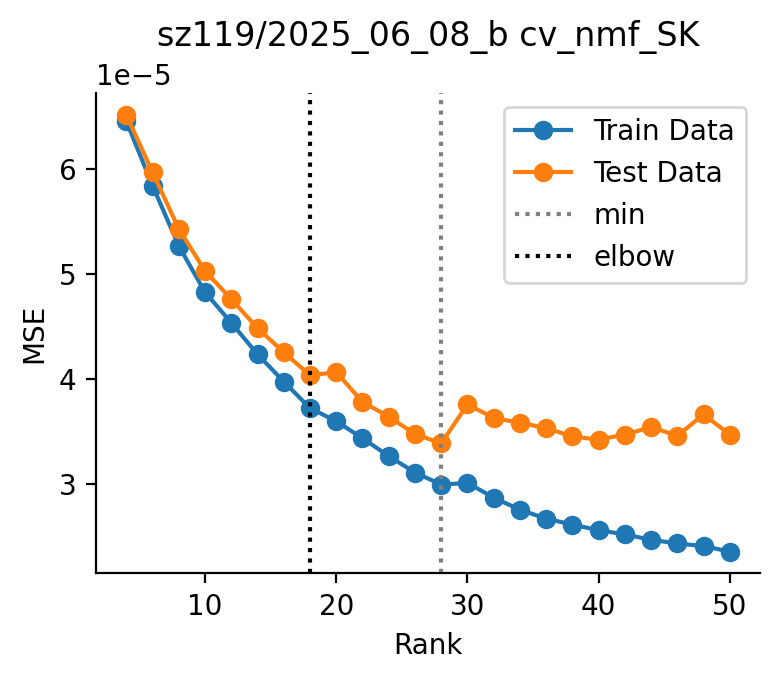

💾 Saved NumPy dict at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.npy
📊 Updated Excel summary at C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\cv_nmf\cv_results.xlsx
✅ All datasets processed successfully.


In [53]:
cv_dict = cv_nmf_run_all(data_root)

In [15]:
# selected = ['sz004/2021-11-30_c']

In [12]:
# A.W. implementation

In [16]:
# r_max = 50

In [2]:
# cv_dict_aw = cv_nmf_run_AW(data_root, selected_datasets=selected)

In [10]:
# sklearn with np.median imputation 

✅ Loaded preprocessed npy for sz004\2021-11-30_c: (3600, 3025)
Fitting NMF with rank = 1
Finished running for rank: 1 | Training error: 0.0003, Test error: 0.0004
Fitting NMF with rank = 3
Finished running for rank: 3 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 5
Finished running for rank: 5 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 7
Finished running for rank: 7 | Training error: 0.0002, Test error: 0.0002
Fitting NMF with rank = 9
Finished running for rank: 9 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 11
Finished running for rank: 11 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 13
Finished running for rank: 13 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 15
Finished running for rank: 15 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 17
Finished running for rank: 17 | Training error: 0.0001, Test error: 0.0001
Fitting NMF with rank = 19
Fi

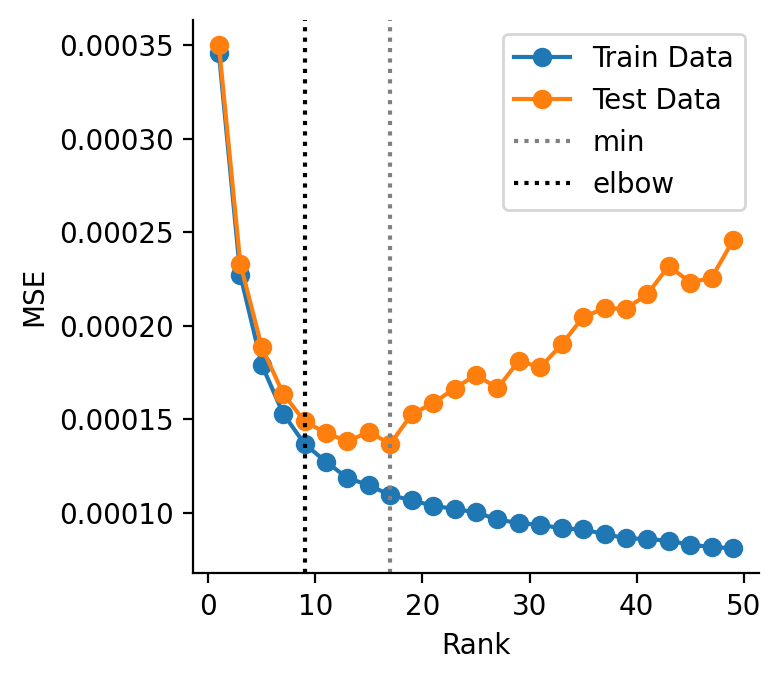

❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\cv_nmf\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\downsampled_tiff\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\downsampled_tiff\python_bilinear\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\exploratory_analysis\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\NMF\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\NMF\corr_violin\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\NMF\nmf_final\preprocessed_tiff.npy
❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\NMF\nmf_finalroi_to_fi

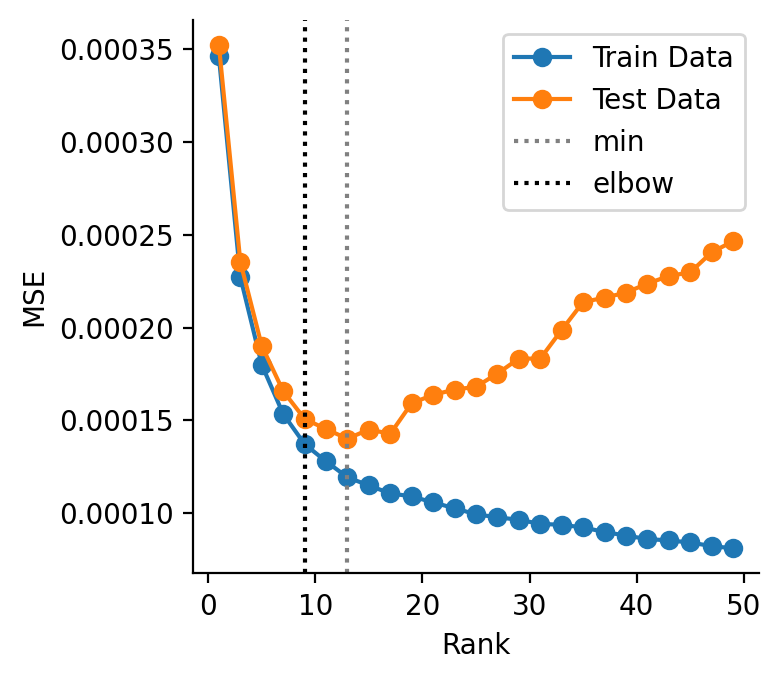

❌ Could not find C:\Users\zaggila\Documents\pixelNMF\data_proc\pixels\sz004\2021-11-30_c\save_dir_preprocessing\preprocessed_tiff.npy


In [15]:
cv_dict_sz004_c = cv_nmf_run_all(data_root, selected_datasets=selected)

In [51]:
# print(cv_dict_sz101['sz101_2025_04_13_b']['test_err'])

In [ ]:
#run cv_nmf batch 
cv_dict = cv_nmf_run_all(data_root)

In [ ]:
np.save('cv_results.npy', cv_dict)
print('Saved cv_results')

In [ ]:
print(cv_dict)

In [1]:
import pandas as pd

df = pd.DataFrame.from_dict(cv_dict, orient='idx')
excel_path = os.path.join(data_root, 'cv_results.xlsx')
df.to_excel(excel_path)
print('Saved in Excel')

NameError: name 'cv_dict' is not defined